<a href="https://colab.research.google.com/github/OlgaShevel/Computer-Vision-Projects/blob/main/!DICOM_reconstr_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pydicom

**Реконструкция анатомических проекций**


В примере ниже в упрощенном виде на Python реализована MPR (мультипланарная реконструкция): сагиттальная и корональная проекции  воссоздаются из аксиального плана для форм организации файлов DICOM Series.



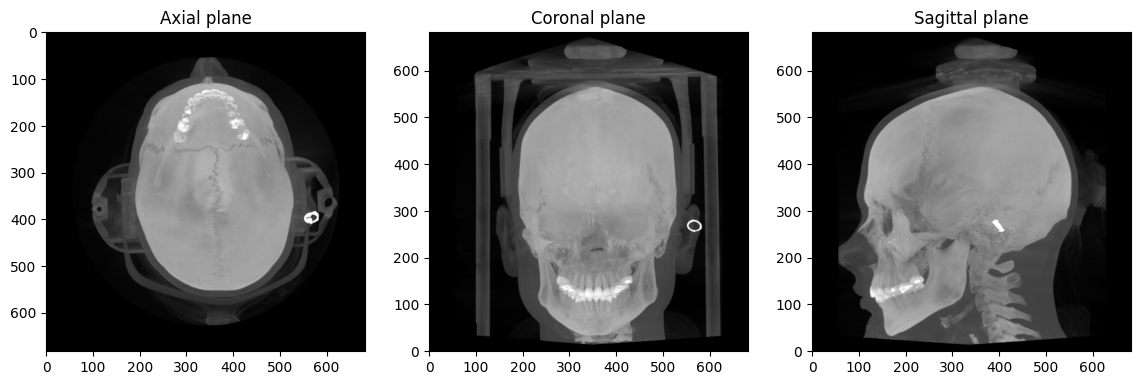

In [5]:
# Функция реконструкции анатомических проекций из формы DICOM Series

def general_image(folder_path):

    """
    Реконструирует анатомические проекции из DICOM-файлов в указанной папке.

    Параметры:
    folder_path (str): Путь к папке, содержащей DICOM файлы.

    Возвращает:
    None: Функция сохраняет проекции в формате PNG в папке 'GENERAL_IMAGE' на Google Диске.

    Вызывает исключения:
    FileNotFoundError: Если папка folder_path не существует.
    ValueError: Если в папке нет DICOM файлов.
    """

    files = os.listdir(folder_path)
    files.sort()

    # Загрузим первый файл папки, чтобы получить размеры изображения
    first_file = pydicom.dcmread(os.path.join(folder_path, files[0]))
    rows = int(first_file.Rows)
    columns = int(first_file.Columns)

    # Создадим массив для хранения данных изображения
    image_data = np.zeros((len(files), rows, columns))

    save_path = '/content/drive/MyDrive/LECTIA_DICOM/GENERAL_IMAGE'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for i, file in enumerate(files):
        ds = pydicom.dcmread(os.path.join(folder_path, file))
        image_data[i, :, :] = ds.pixel_array

    fig, axes = plt.subplots(1, 3, figsize=(14, 10))

    gen_image0 = np.max(image_data, axis=0)
    axes[0].imshow(gen_image0, cmap='gray')
    axes[0].set_title('Axial plane')
    plt.imsave(os.path.join(save_path, 'general_image0.png'), gen_image0)

    gen_image1 = np.max(image_data, axis=1)
    axes[1].imshow(gen_image1, origin='lower', cmap='gray')
    axes[1].set_title('Coronal plane')
    plt.imsave(os.path.join(save_path, 'general_image1.png'), gen_image1)

    gen_image2 = np.max(image_data, axis=2)
    axes[2].imshow(gen_image2, origin='lower', cmap='gray')
    axes[2].set_title('Sagittal plane')
    plt.imsave(os.path.join(save_path, 'general_image2.png'), gen_image2)
    plt.title('Sagittal plane')

folder_path = '/content/drive/MyDrive/PROJECT_DICOM/149484'
general_image(folder_path)

**Реконструкция объёма из файлов DICOM**

Изображение в псевдо-3D также можно воссоздать из одной из проекций.
Как правило, это аксиальная проекция, хотя и не обязательно.

В примере ниже из сессии файлов в аксиальной проекции воссозданы 3D-представления грудной клетки человека и легких при помощи разной радиоплотности (единиц Хаунсфилда HU).

В принципе, ничто не мешает воссоздать объем в интерактиве, хоть в Matplotlib, хоть в Plotly.

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

Список элементов в директории: ['000093.dcm', '000011.dcm', '000002.dcm', '000010.dcm', '000039.dcm', '000031.dcm', '000061.dcm', '000068.dcm', '000066.dcm', '000056.dcm', '000096.dcm', '000009.dcm', '000018.dcm', '000015.dcm', '000097.dcm', '000072.dcm', '000043.dcm', '000078.dcm', '000084.dcm', '000088.dcm', '000006.dcm', '000053.dcm', '000048.dcm', '000026.dcm', '000049.dcm', '000089.dcm', '000098.dcm', '000040.dcm', '000034.dcm', '000070.dcm', '000062.dcm', '000035.dcm', '000003.dcm', '000051.dcm', '000022.dcm', '000054.dcm', '000037.dcm', '000052.dcm', '000045.dcm', '000028.dcm', '000079.dcm', '000013.dcm', '000012.dcm', '000082.dcm', '000067.dcm', '000027.dcm', '000025.dcm', '000065.dcm', '000029.dcm', '000085.dcm', '000050.dcm', '000007.dcm', '000000.dcm', '000081.dcm', '000083.dcm', '000080.dcm', '000016.dcm', '000005.dcm', '000058.dcm', '000087.dcm', '000017.dcm', '000069.dcm', '000055.dcm', '000092.dcm', '000020.dcm', '000033.dcm', '000090.dcm', '000074.dcm', '000042.dcm', '0

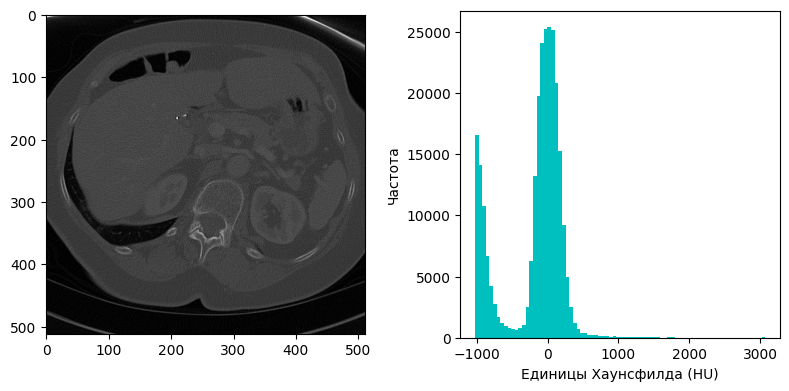

In [ ]:
def load_scan(path):
    """Загрузить DICOM-срезы из указанного пути."""
    slices = [pydicom.dcmread(os.path.join(path, s)) for s in os.listdir(path) if s.endswith('.dcm')]
    if not slices:
        print(f"Нет файлов DICOM в папке: {path}")
        return []
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

def get_pixels_hu(slices):
    """Преобразование DICOM-срезов в массив пикселей с единицами Хаунсфилда (HU)."""
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

INPUT_FOLDER = '/content/DATA_DICOM_Chest'

# Проверяем наличие файлов в директории
print("Список элементов в директории:", os.listdir(INPUT_FOLDER))

# Ищем DICOM-файлы
patient_found = False
first_patient = None
patients = os.listdir(INPUT_FOLDER)

# Цикл по элементам в папке
for patient in patients:
    patient_path = os.path.join(INPUT_FOLDER, patient)
    print(f"Проверка пути: {patient_path}")

    # Проверяем, является ли элемент папкой и содержит ли он DICOM-файлы
    if os.path.isdir(patient_path):
        first_patient = load_scan(patient_path)
        if first_patient:
            patient_found = True
            break
    else:
        if patient.endswith('.dcm'):
            print(f"Найден DICOM файл: {patient}")
            # Возможный вариант загрузки на прямую
            first_patient = [pydicom.dcmread(os.path.join(INPUT_FOLDER, patient))]
            patient_found = True
            break

if patient_found and first_patient:
    first_patient_pixels = get_pixels_hu(first_patient)

    # Выводим изображение и гистограмму
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(first_patient_pixels[0], cmap=plt.cm.gray)

    # Правая часть: гистограмма
    ax2.hist(first_patient_pixels.flatten(), bins=80, color='c')
    ax2.set_xlabel("Единицы Хаунсфилда (HU)")
    ax2.set_ylabel("Частота")
    plt.tight_layout()
    plt.show()

else:
    print("Не удалось найти директорию с DICOM файлами или DICOM файлы отсутствуют.")

In [ ]:
def load_scan(path):
    slices = [pydicom.dcmread(os.path.join(path, s)) for s in os.listdir(path) if s.endswith('.dcm')]

    if not slices:
        print(f"Нет файлов DICOM в папке: {path}")
        return []

    # Отсортировать срезы по положению
    if len(slices) > 1:
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    else:
        print("Только один срез, сортировка не требуется.")

    try:
        if len(slices) > 1:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        else:
            slice_thickness = 1  # Для одного среза толщина не определена
    except:
        try:
            if len(slices) > 1:
                slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
            else:
                slice_thickness = 1  # Для одного среза толщина не определена
        except:
            print("Не удалось определить толщину среза.")
            return []

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

first_patient = load_scan(INPUT_FOLDER)
print("Количество срезов:", len(first_patient))

first_patient_pixels = get_pixels_hu(first_patient)
print("Размеры после загрузки:", first_patient_pixels.shape)

Количество срезов: 99
Размеры после загрузки: (99, 512, 512)


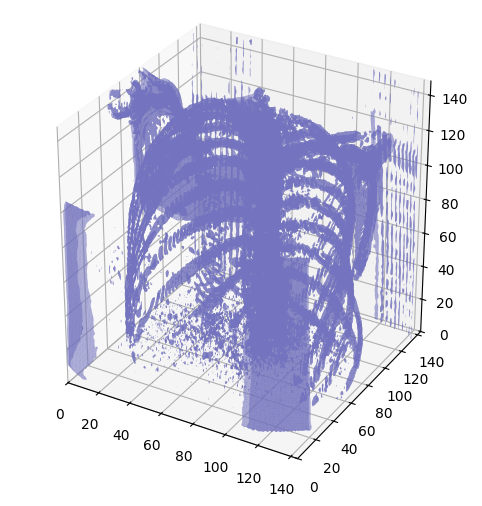

In [ ]:
def resample(image, scan, new_spacing=[2,2,2]):
    # Определить текущее расстояние между пикселями
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

def plot_3d(image, threshold=-300):
    # Вертикальная позиция сканера (голова сверху)
    p = image.transpose(2,1,0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    # Добавить масштабирование осей
    ax.set_aspect('equal')  # Чтобы сохранить пропорции
    # ax.set_aspect('auto')  # Чтобы автоматически масштабировать

    # Если нужно вытянуть в определенном направлении set_box_aspect
    ax.set_box_aspect((1, 1, 1.1))  # Вытянуть по оси Z

    plt.show()

# при вызове уменьшим количество между центрами пикселей в 2 раза, чтобы не перегружать OЗУ
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [2,2,2])
plot_3d(pix_resampled, 300)

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    background_label = labels[0,0,0]
    binary_image[background_label == labels] = 2

    if fill_lung_structures:
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            if l_max is not None:
                binary_image[i][labeling != l_max] = 1

    binary_image -= 1
    binary_image = 1-binary_image

    #Удалитm ненужные воздушные карманы
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:
        binary_image[labels != l_max] = 0

    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

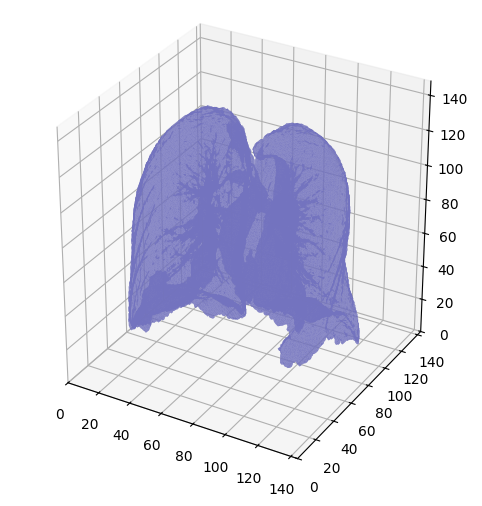

In [ ]:
plot_3d(segmented_lungs, 0)

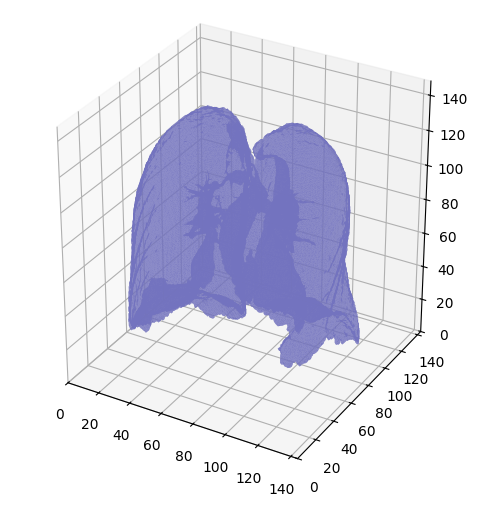

In [ ]:
plot_3d(segmented_lungs_fill, 0)

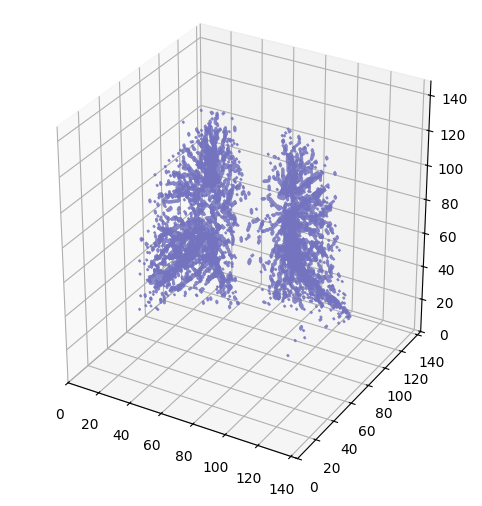

In [ ]:
# структуры внутри легких

plot_3d(segmented_lungs_fill - segmented_lungs, 0)